#**semi-supervised-orgspec-epitope-prediction"**

---




In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/orgspec-epitope-prediction')  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/training-Ovolvulus.csv
./input/02_holdout.csv
./input/new_train_ovolvulus.csv
./input/ov_holdout.csv
./input/ov_training.csv


In [5]:
feature_columns = {'feat_VHSE5', 'feat_BLOSUM1', 'feat_F6', 'feat_MSWHIM2', 'feat_PP2', 'feat_KF3', 'feat_VHSE1', 'feat_Z1', 'feat_Z4', 'feat_F1', 'feat_BLOSUM7', 'feat_ST5', 'feat_O_atoms', 'feat_ProtFP4', 'feat_PP3', 'feat_PP1', 'feat_ST7'}
target = 'Class'

In [6]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle

# Importing the dataset
train_ovolvulus = pd.read_csv('./input/ov_training.csv')

train_ovolvulus.replace([np.inf, -np.inf], np.nan, inplace=True)
train_ovolvulus.dropna(inplace=True)

train_ovolvulus = shuffle(train_ovolvulus, random_state=1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#train_ovolvulus = train_ovolvulus.iloc[0:int(len(train_ovolvulus))]

noisy_train_ovolvulus = train_ovolvulus.loc[train_ovolvulus['Info_evidence_type']=='Epitope-containing region']

exact_train_ovolvulus = train_ovolvulus.loc[train_ovolvulus['Info_evidence_type']=='Exact Epitope']

df_X_1_noisy = noisy_train_ovolvulus.iloc[0:25]

df_X_1_exact = exact_train_ovolvulus.iloc[0:25]


df_X_1 = pd.concat([df_X_1_noisy, df_X_1_exact])


df_X_1 = shuffle(df_X_1, random_state=1)

df_X_1['Class'] = df_X_1['Class'].apply(lambda x: 0 if x == -1 else x)



df_X_2_part1 = noisy_train_ovolvulus.iloc[101:4101]
df_X_2_part2 = exact_train_ovolvulus[26:4826]



#df_X_2_part1 = train_ovolvulus.iloc[101:901]
#df_X_2_part2 = exact_train_ovolvulus[0:800]

df_X_2 = pd.concat([df_X_2_part1, df_X_2_part2])
df_X_2['Class'] = df_X_2['Class'].apply(lambda x: 0 if x == -1 else x)

df_X_2 = shuffle(df_X_2, random_state=1)



X_1 = df_X_1[feature_columns]
y_1 = df_X_1[target]

X_2 = df_X_2[feature_columns]
y_2 = df_X_2[target]


y_1_2 = np.concatenate((y_1, y_2.apply(lambda x: -1)))
X_1_2 = np.concatenate((X_1, X_2))

In [8]:
# Importing the dataset
holdout_ovolvulus = pd.read_csv('./input/ov_holdout.csv')

holdout_ovolvulus.replace([np.inf, -np.inf], np.nan, inplace=True)
holdout_ovolvulus.dropna(inplace=True)

holdout_ovolvulus = shuffle(holdout_ovolvulus, random_state=1)

holdout_ovolvulus = holdout_ovolvulus.iloc[0:int(len(holdout_ovolvulus)/2)]

df_X_3 = holdout_ovolvulus

df_X_3['Class'] = df_X_3['Class'].apply(lambda x: 0 if x == -1 else x)

X_3 = df_X_3[feature_columns]
y_3 = df_X_3[target]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_X_1.Class.value_counts()

1    25
0    25
Name: Class, dtype: int64

In [10]:
#Basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [11]:
#!pip install pomegranate
#import pomegranate as pg
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

In [12]:
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1) #i'm locking seed at the begining since we will use some heavy RNG stuff, be aware

In [13]:
index = ['Algorithm', 'ROC AUC']
results = pd.DataFrame(columns=index)

In [14]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

model = RandomForestClassifier();

model.fit(X_1, y_1)

preds = model.predict(X_3)

print("ROC_AUC:", roc_auc_score(y_3, preds))

print(classification_report(y_3, preds))

ROC_AUC: 0.639052341282883
              precision    recall  f1-score   support

           0       0.58      0.65      0.61      1175
           1       0.69      0.63      0.66      1489

    accuracy                           0.64      2664
   macro avg       0.64      0.64      0.64      2664
weighted avg       0.64      0.64      0.64      2664



**Label Propagation**

In [15]:
def label_prop_test(kernel, params_list, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        for g in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    if kernel == 'knn':
        for n in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8));
    plt.plot(params_list, roc_scores)
    plt.title('Label Propagation ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(params_list[np.argmax(roc_scores)]))


<Figure size 1440x720 with 0 Axes>

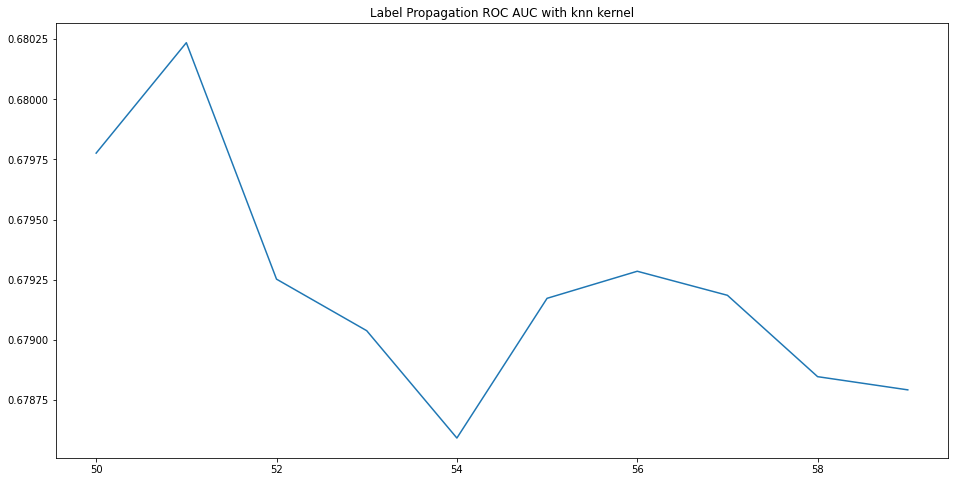

Best metrics value is at 51


In [16]:
ns = np.arange(50,60)
label_prop_test('knn', ns, X_1_2, X_3, y_1_2, y_3)


In [18]:
# define model
#model = LabelPropagation(kernel='rbf', gamma=2e-5, max_iter=100000, tol=0.0001)
model = LabelPropagation(kernel='knn',n_neighbors=51, gamma=30, max_iter=2000)
# fit model on training dataset
model.fit(X_1_2, y_1_2)
# make predictions
predicted_labels = model.predict(X_3)
true_labels = y_3

print("ROC_AUC:", roc_auc_score(y_3, predicted_labels))
print(classification_report(true_labels, predicted_labels))

ROC_AUC: 0.6307068859580184
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1175
           1       0.67      0.69      0.68      1489

    accuracy                           0.64      2664
   macro avg       0.63      0.63      0.63      2664
weighted avg       0.64      0.64      0.64      2664

